In [1]:
%load_ext autoreload
import ddls

In [2]:
%autoreload
from ddls.devices.processors.gpus.A100 import A100

node_config = {'type_1':
                  {
                      'num_nodes': 100,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100()
                              }
                          ]
                  }
              }

print(node_config)

{'type_1': {'num_nodes': 100, 'workers_config': [{'num_workers': 4, 'worker': <ddls.devices.processors.gpus.A100.A100 object at 0x7ff845119910>}]}}


In [3]:
topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

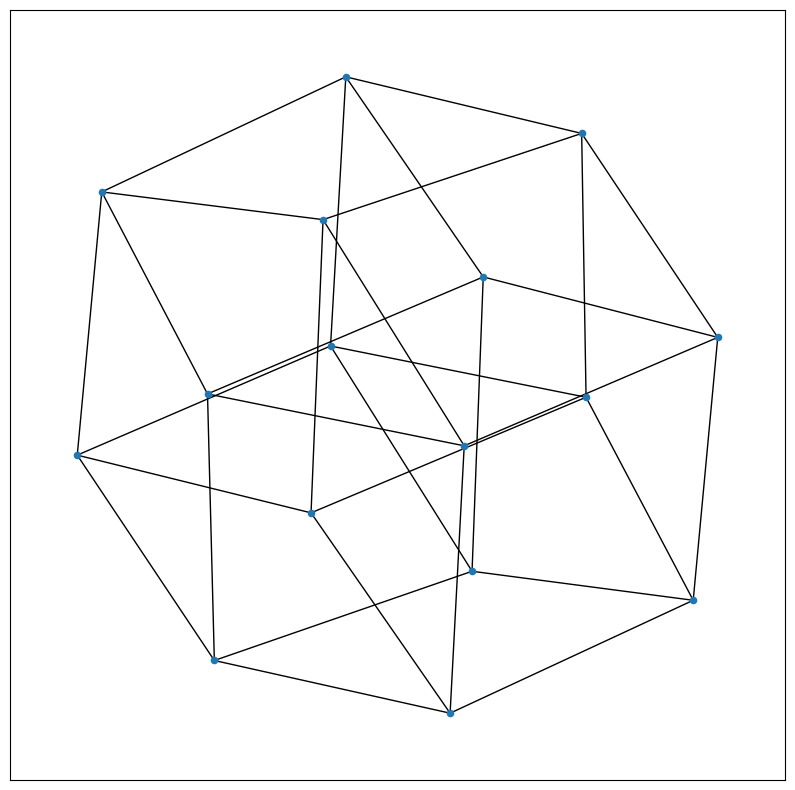

In [4]:
%autoreload
from ddls.clusters.cluster import Cluster

env = Cluster(topology_config=topology_config,
              node_config=node_config)
env.topology.render()

In [5]:
import tensorflow as tf

In [6]:
tf.CostGraphDef()

AttributeError: module 'tensorflow' has no attribute 'CostGraphDef'